In [1]:
import numpy as np
import scipy.linalg
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

import dynetx as dn

from general_graph_utils import *

# plot formatting
plt.rc("text", usetex=False)
plt.rc("font", family = "serif")
plt.rc("figure",figsize=(10,8))
%config InlineBackend.figure_format = 'retina'

**Goals of simulation**

* Initialize a system of N particles in finite space
* Each particle assigned a speed v and direction of motion r
* Each particle exists in one of two states:
    * "Run" state: particle moves in a straight line forming a polymer link with finite probability => adds an edge
    * "Tumble" state: particle changes direction => adds a node
   

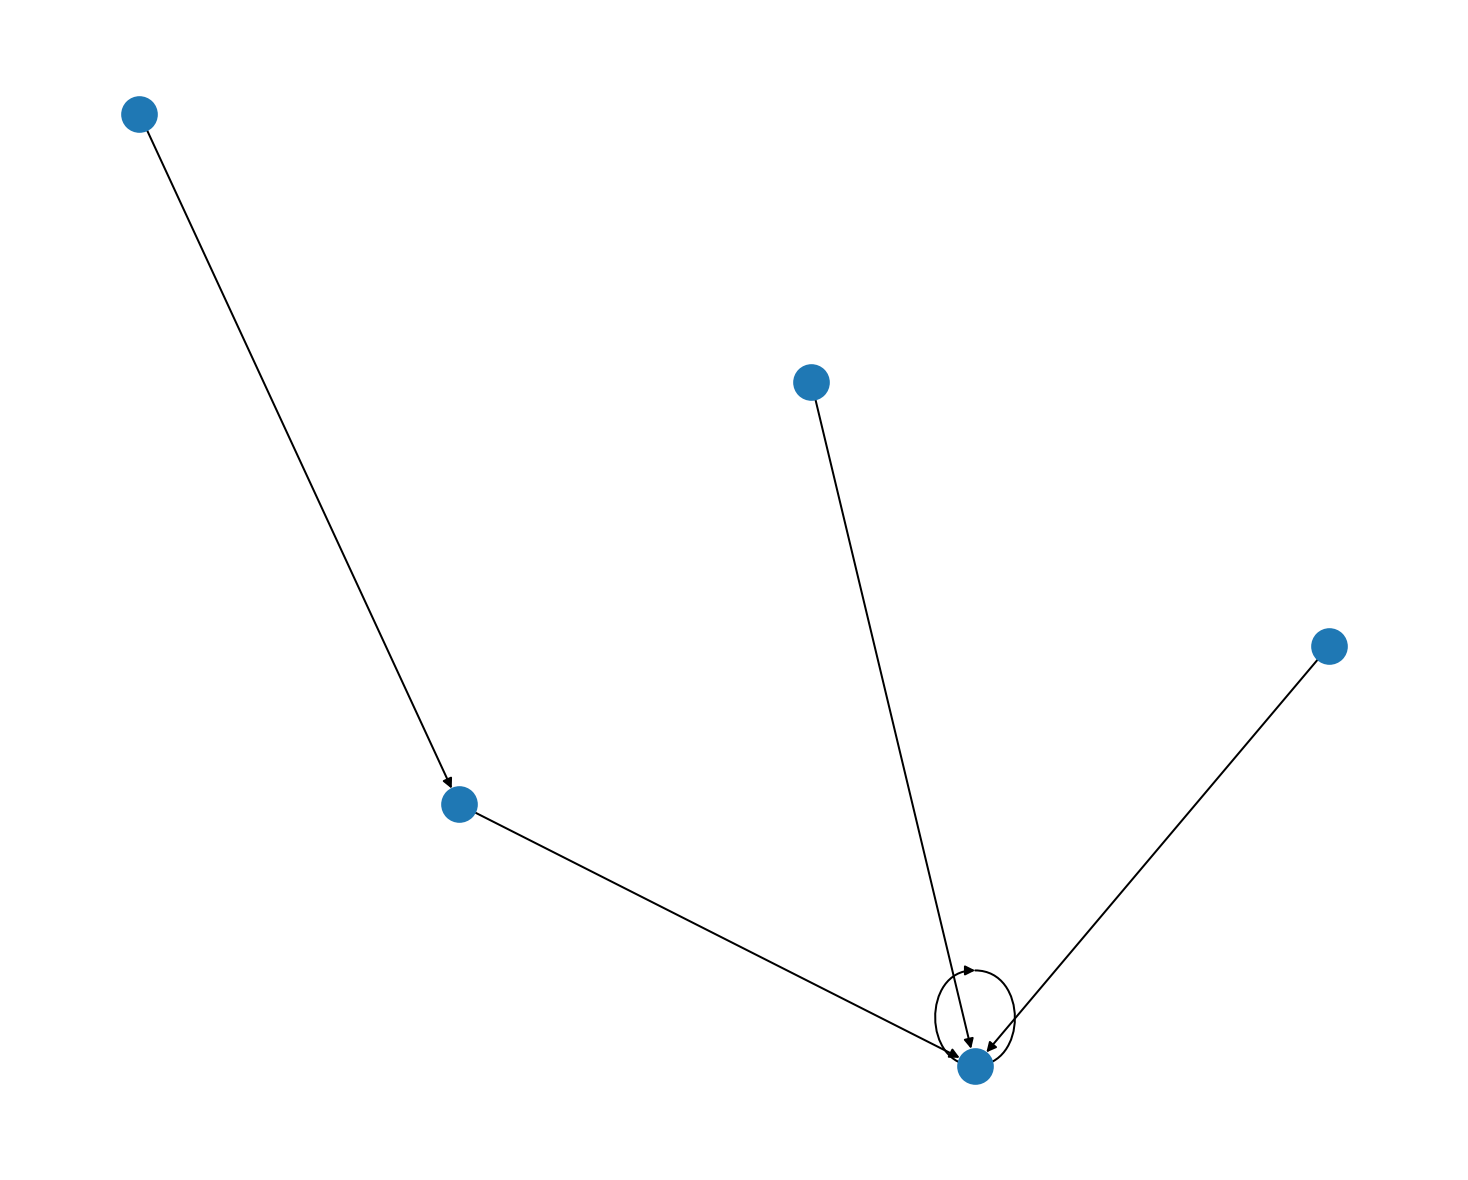

In [13]:
g = dn.DynDiGraph()
time = 0 # initial time

# initial particle locations
p_1 = 1 
p_2 = 2
p_3 = 3
p_4 = 4
p_5 = 5

# dynamically create network
while time < 10:
    v_1 = np.ran
    v_2 = 
    v_3 = 
    v_4 = 
    v_5 = 
    
    g.add_interaction(u=p_1, v=v_1, t=time)
    g.add_interaction(u=p_2, v=v_2, t=0)
    g.add_interaction(u=p_3, v=v_3, t=0)
    g.add_interaction(u=p_4, v=v_4, t=0)
    g.add_interaction(u=p_5, v=v_5, t=0)
    
    p_1 = v_1
    p_2 = v_2
    p_3 = v_3
    p_4 = v_4
    p_5 = v_5
    
    time +=1

nx.draw(g)

In [ ]:
n = 5 # number of particles

In [3]:
n = 5 

G = nx.DiGraph()
G_ud = nx.Graph()

# determine the number of nodes in G
G_size = n

# add nodes to G and G_ud
nodes = np.arange(1,G_size+1,step=1)
G.add_nodes_from(nodes)
G_ud.add_nodes_from(nodes)

# add edges until the graph is strongly connected
while nx.is_strongly_connected(G) == False:
    u, v = np.random.choice(nodes, size=2,replace=False)
    G.add_edge(u,v)
    G_ud.add_edge(u,v)
    
    # add edges such that the graph is fully reversible
for edge in G.edges:
    u = edge[0]
    v = edge[1]
    if G.has_edge(v,u) == False:
        G.add_edge(v,u)
        G_ud.add_edge(v,u)

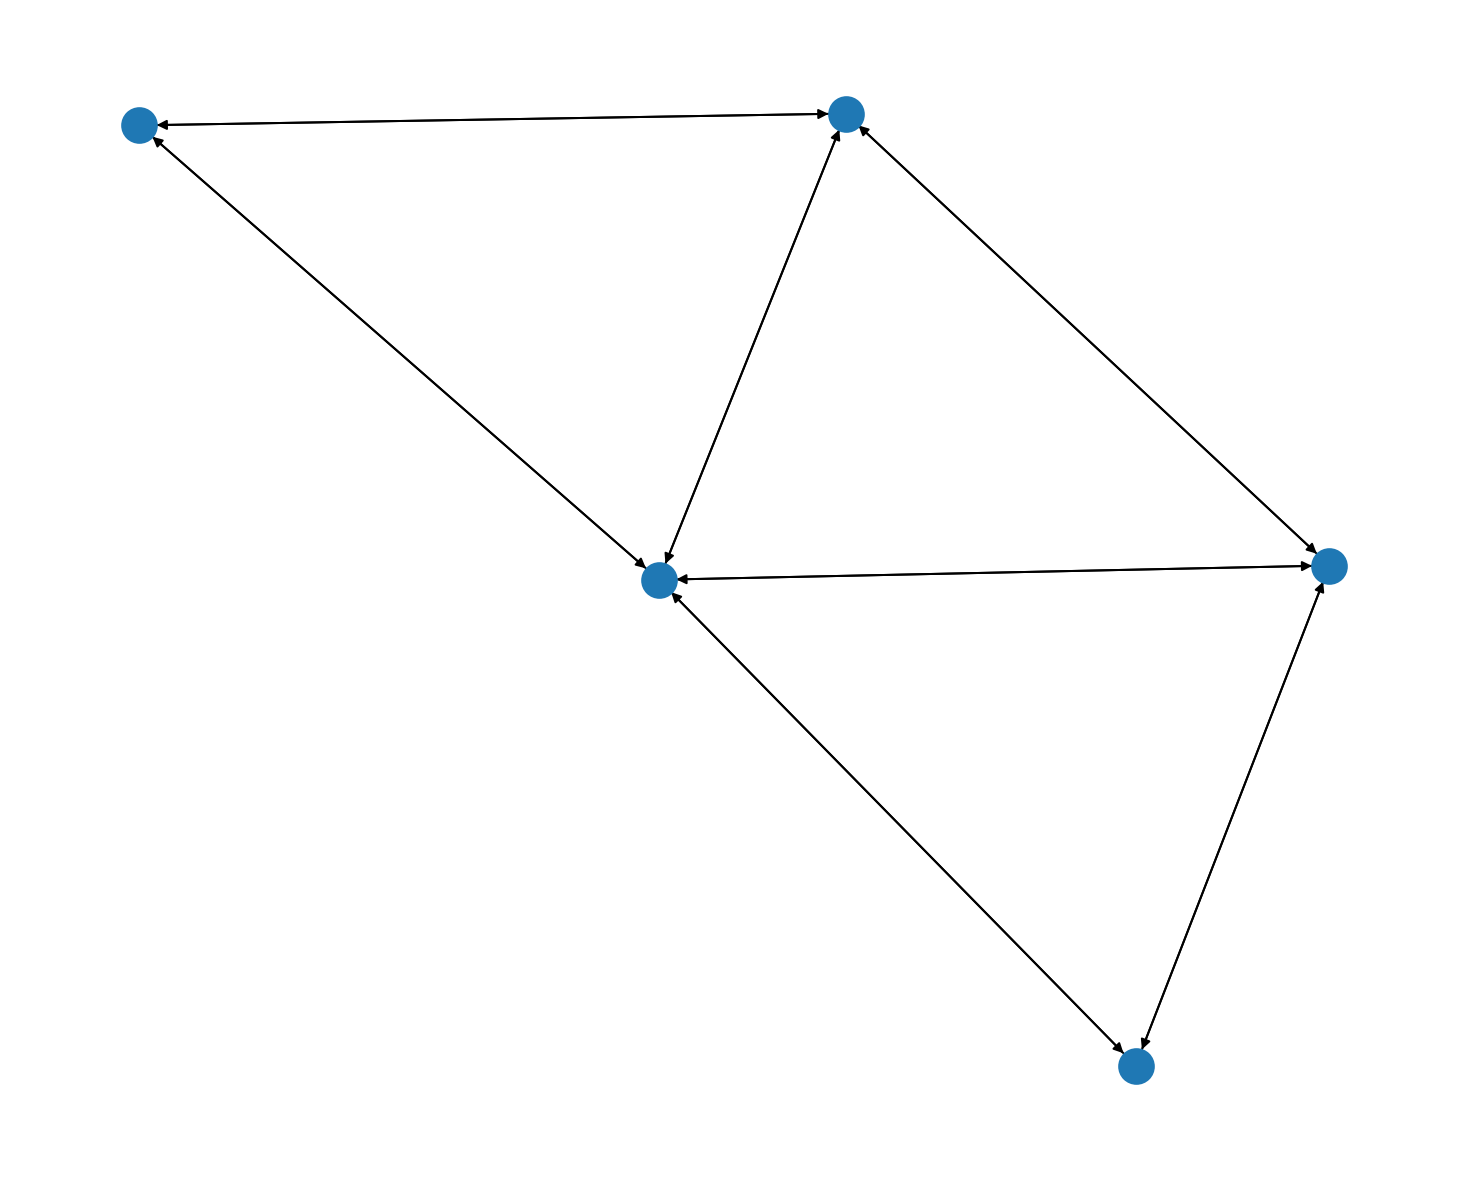

In [4]:
nx.draw(G)